<a href="https://colab.research.google.com/github/aniketAnvekar/Breast-Cancer-Classification/blob/main/Transfer_Learning_VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from glob import glob

In [ ]:
my_paths = []

for name in glob('/content/drive/MyDrive/Breast_Cancer_Classification/data/dataset/*', recursive=True):
  my_paths.append(name)

In [ ]:
total_imaages = []
my_paths = my_paths[:35]
for i in my_paths:
  total_imaages += glob(i+'/*/*.png', recursive=True)

len(total_imaages)

In [ ]:
images = total_imaages[:30000]

images[:5]

In [ ]:
class0_dict = {} # 0 = no cancer
class1_dict = {} # 1 = cancer

for filename in images:
    if filename.endswith("class0.png"):
         class0_dict[filename] = 'Yes'
    else:
        class1_dict[filename] = 'No'

In [ ]:
data = {k: class0_dict[k] for k in sorted(class0_dict.keys())[:4]}

In [ ]:
class0_dict = {k: class0_dict[k] for k in sorted(class0_dict.keys())[:6593]}
len(class0_dict)

In [ ]:
sample_data = {**class0_dict, **class1_dict}
len(sample_data)

In [ ]:
sample_df = pd.DataFrame(sample_data.items(), columns=['Path', 'label'])
sample_df.head()

In [ ]:
sample_df.to_csv('/content/drive/MyDrive/Breast_Cancer_Classification/data/sample_df.csv')

In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pylab as plt

In [2]:
sample_df = pd.read_csv("/content/drive/MyDrive/Breast_Cancer_Classification/data/sample_df.csv")
sample_df.head()

,Unnamed: 0,Path,label
0,0,/content/drive/MyDrive/Breast_Cancer_Classific...,Yes
1,1,/content/drive/MyDrive/Breast_Cancer_Classific...,Yes
2,2,/content/drive/MyDrive/Breast_Cancer_Classific...,Yes
3,3,/content/drive/MyDrive/Breast_Cancer_Classific...,Yes
4,4,/content/drive/MyDrive/Breast_Cancer_Classific...,Yes


In [3]:
sample_df['label'].value_counts()

No     6593
Yes    6593
Name: label, dtype: int64

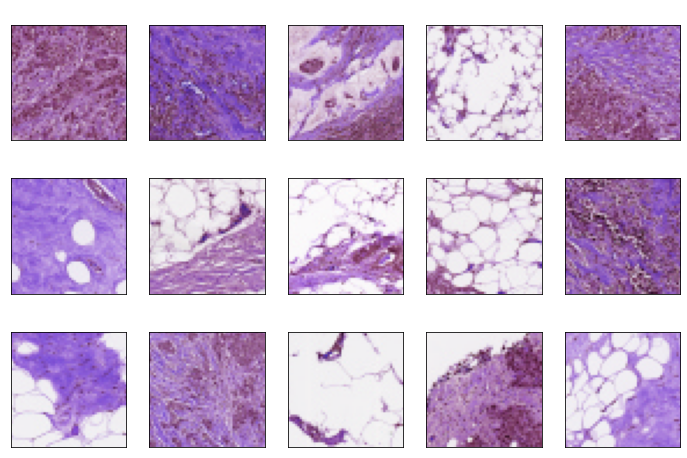

In [ ]:
import cv2

plt.figure(figsize=(12,8))
for i in range(15):
    random = np.random.randint(1,len(sample_df))
    plt.subplot(3,5,i+1)
    plt.imshow(cv2.imread(sample_df.loc[random,"Path"]))
    plt.title(sample_df.loc[random, "label"], size = 15, color = "white") 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(sample_df, train_size=0.80, random_state=42)
train_new, valid = train_test_split(train, train_size=0.85, random_state=42)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")

train set shape: (8965, 3)
test set shape: (2638, 3)
validation set shape: (1583, 3)


In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

In [6]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train_new,
                                              x_col = 'Path', y_col ='label',
                                              target_size = (224,224), batch_size = 32, 
                                              class_mode = 'binary', shuffle = True)

val_gen = train_datagen.flow_from_dataframe(valid, 
                                            target_size=(224,224), x_col = 'Path', y_col ='label', 
                                            class_mode='binary',
                                            batch_size= 16, shuffle=True)

test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (224,224), x_col = 'Path', y_col ='label',
                                             class_mode = 'binary',
                                            batch_size = 16, shuffle = False)

Found 8965 validated image filenames belonging to 2 classes.
Found 1583 validated image filenames belonging to 2 classes.
Found 2638 validated image filenames belonging to 2 classes.


In [8]:
train_gen.class_indices

{'No': 0, 'Yes': 1}

In [7]:
from tensorflow import keras

In [9]:
base_model = keras.applications.VGG19(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False,
)

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
for layer in base_model.layers:
  layer.trainable = False

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D

x = Flatten()(base_model.output)

prediction = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=prediction)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [14]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_____________________________________________

In [12]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

In [21]:
model.compile(loss='binary_crossentropy', optimizer=tf.optimizers.Adam(learning_rate= 0.00001), metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(train_gen, validation_data = val_gen, epochs = 15, 
                    callbacks = [es], verbose = 1)

Epoch 1/15
281/281 [==============================] - 2450s 9s/step - loss: 0.6536 - accuracy: 0.6156 - val_loss: 0.5898 - val_accuracy: 0.7252
Epoch 2/15
281/281 [==============================] - 174s 618ms/step - loss: 0.5671 - accuracy: 0.7341 - val_loss: 0.5358 - val_accuracy: 0.7505
Epoch 3/15
281/281 [==============================] - 176s 627ms/step - loss: 0.5304 - accuracy: 0.7534 - val_loss: 0.5025 - val_accuracy: 0.7625
Epoch 4/15
281/281 [==============================] - 178s 634ms/step - loss: 0.5072 - accuracy: 0.7674 - val_loss: 0.4903 - val_accuracy: 0.7707
Epoch 5/15
281/281 [==============================] - 179s 637ms/step - loss: 0.4921 - accuracy: 0.7766 - val_loss: 0.4793 - val_accuracy: 0.7814
Epoch 6/15
281/281 [==============================] - 178s 632ms/step - loss: 0.4790 - accuracy: 0.7840 - val_loss: 0.4623 - val_accuracy: 0.7808
Epoch 7/15
281/281 [==============================] - 178s 633ms/step - loss: 0.4727 - accuracy: 0.7837 - val_loss: 0.4533 - v

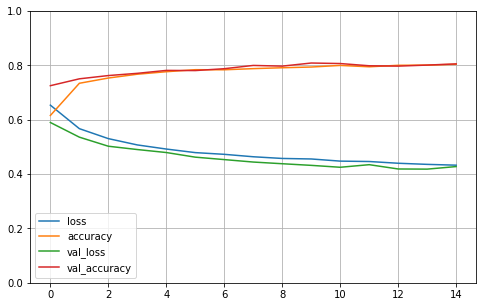

In [23]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()